In [1]:
# ------------------ install kaggle & download via Kaggle API ------------------
!pip install kaggle --quiet

import os
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dest = "/Users/souvikbag/Library/CloudStorage/OneDrive-UniversityofMissouri/Research/dementia/data"
api.dataset_download_files("samuelcortinhas/time-series-practice-dataset", path=dest, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/time-series-practice-dataset


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


Importing plotly failed. Interactive plots will not work.


In [4]:
file_path = "data/train.csv"
data = pd.read_csv(file_path)

Data preprocessing

In [5]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)

In [6]:
number_sold = data['number_sold']
number_sold = number_sold.dropna()

print(f"Number of missing values in number_sold: {number_sold.isnull().sum()}")

Number of missing values in number_sold: 0


In [7]:
number_sold = number_sold[1:3000]


Plot the average cost time series

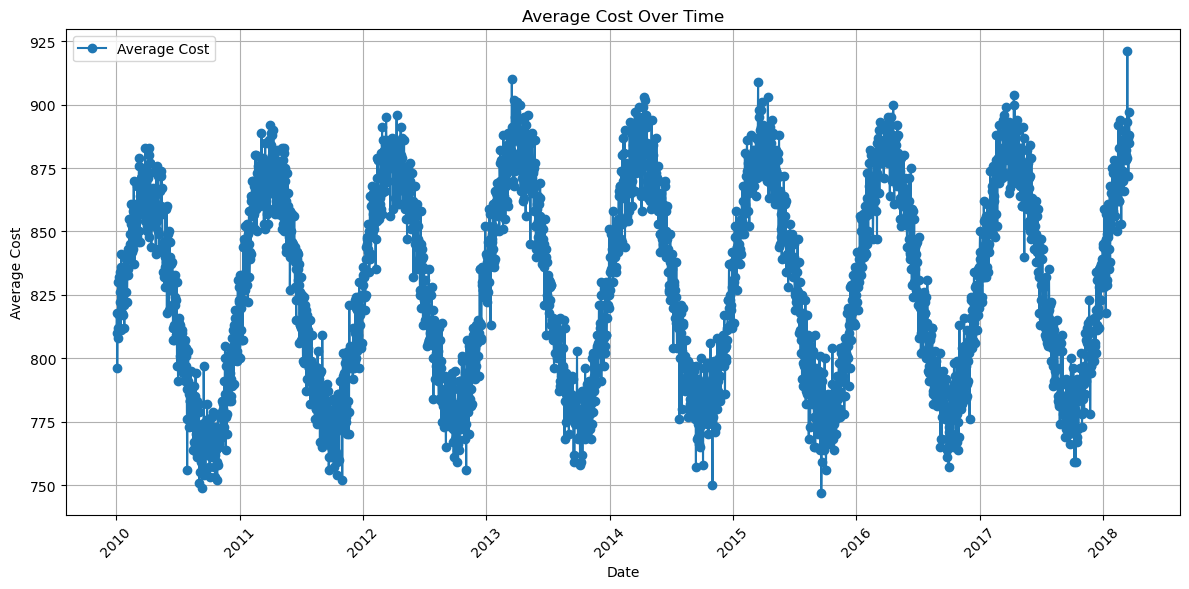

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(number_sold, marker='o', label='Average Cost')
plt.title('Average Cost Over Time')
plt.xlabel('Date')
plt.ylabel('Average Cost')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

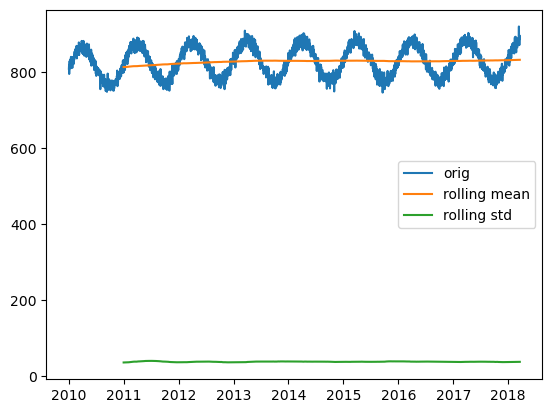

In [16]:
rol_mean = number_sold.rolling(window=365).mean()
rol_std  = number_sold.rolling(window=365).std()
plt.plot(number_sold, label="orig")
plt.plot(rol_mean, label="rolling mean")
plt.plot(rol_std,  label="rolling std")
plt.legend(); plt.show()



In [17]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(number_sold.dropna())
print(f"ADF statistic = {result[0]:.3f}")
print(f"p-value = {result[1]:.3f}")
for k, v in result[4].items():
    print(f"  critical value ({k}) = {v:.3f}")


ADF statistic = -4.622
p-value = 0.000
  critical value (1%) = -3.433
  critical value (5%) = -2.863
  critical value (10%) = -2.567


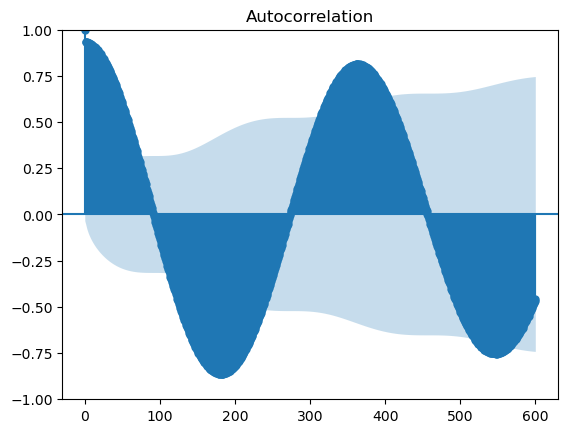

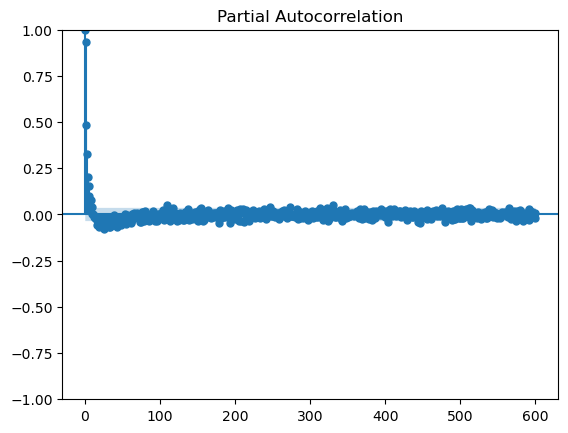

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(number_sold, lags=600); plt.show()
plot_pacf(number_sold, lags=600); plt.show()

In [22]:
# assume ts is your pandas Series
seasonal_diff = number_sold.diff(365).dropna()
plt.show()

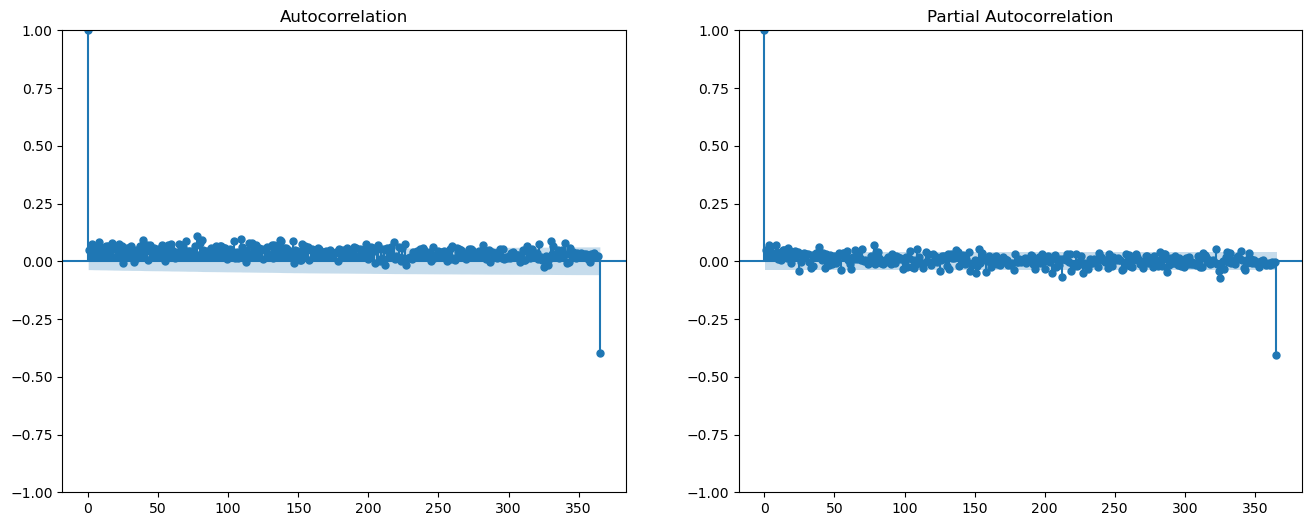

In [26]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(seasonal_diff, lags=365, ax=axes[0])  # ACF plot
plot_pacf(seasonal_diff, lags=365, ax=axes[1])  # PACF plot
plt.show()


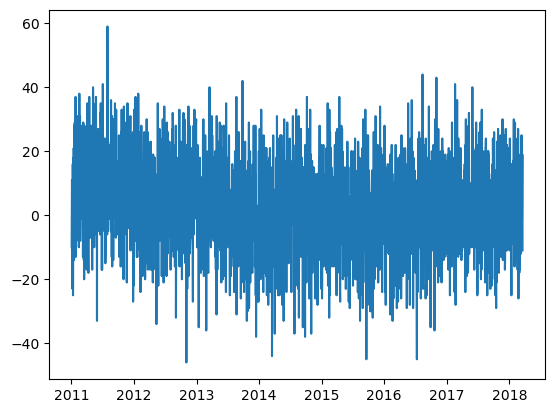

In [23]:
plt.plot(seasonal_diff)

The time series is staitionary

Now we will fit a SARIMA

In [ ]:
arima_model = ARIMA(seasonal_diff, order=(1, 1, 1), seasonal_order=(1, 1, 1, 365))
arima_result = arima_model.fit()
print(arima_result.summary())

# SARIMA
forecast_horizon = 100
arima_forecast = arima_result.get_forecast(steps=forecast_horizon)
arima_pred = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(seasonal_diff, label='Historical Data')
plt.plot(arima_pred.index, arima_pred, label='SARIMA Forecast', color='green')
plt.fill_between(arima_ci.index, arima_ci.iloc[:, 0], arima_ci.iloc[:, 1], color='lightgreen', alpha=0.5)
plt.title('SARIMA Forecast for Number Sold')
plt.xlabel('Date')
plt.ylabel('Average Cost')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/dementia-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dementia-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/dementia-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [12]:
# ------------------ PyTorch LSTM benchmark ------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# hyper-parameters
forecast_horizon = 10
look_back = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # prepare & scale
series = number_sold.values.reshape(-1,1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)


def create_seq(data, lb):
    X, y = [], []
    for i in range(len(data) - lb):
        X.append(data[i:i+lb])      # no extra axis
        y.append(data[i+lb])
    return (torch.tensor(X, dtype=torch.float32),   # (n_samples, lb, 1)
            torch.tensor(y, dtype=torch.float32))


X_all, y_all = create_seq(series_scaled, look_back)
X_train, y_train = X_all[:-forecast_horizon], y_all[:-forecast_horizon]
X_test,  y_test  = X_all[-forecast_horizon:], y_all[-forecast_horizon:]

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=False)

# model
class LSTMNet(nn.Module):
    def __init__(self, in_size, hidden_size, num_layers, dropout):
        super().__init__()
        # multi-layer LSTM with dropout between layers
        self.lstm = nn.LSTM(
            input_size=in_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        # final dropout before the linear head
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, features]
        out, _ = self.lstm(x)                # out: [batch, seq_len, hidden_size]
        last = out[:, -1, :]                 # take last time step
        last = self.drop(last)               # apply dropout
        return self.fc(last)

model = LSTMNet(in_size=1, hidden_size=64, num_layers=3, dropout=0.2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} – train loss: {total_loss/len(train_loader):.4f}")

# forecast
model.eval()
with torch.no_grad():
    X_test_dev = X_test.to(device)
    pred_scaled = model(X_test_dev).cpu().numpy()

# # last observed scaled value:
# last_val = series_s[-forecast_horizon-1, 0]
# pred_s = last_val + pred_scaled
# pred = scaler.inverse_transform(pred_s.reshape(-1,1)).flatten()
# pred_scaled = pred_scaled.reshape(-1, 1)
# lstm_pred = scaler.inverse_transform(pred_scaled).flatten()
# # same for the true values
# y_true_scaled = y_test.unsqueeze(-1).cpu().numpy().reshape(-1, 1)
# y_test_actual = scaler.inverse_transform(y_true_scaled).flatten()

# # plot comparison
# forecast_index = average_cost.index[-forecast_horizon:]
# plt.figure(figsize=(12,6))
# plt.plot(average_cost, label='Historical')
# # plt.plot(forecast_index, arima_pred, '--', label='SARIMA Forecast')
# plt.plot(forecast_index, pred, ':', label='PyTorch LSTM Forecast')
# plt.title('SARIMA vs PyTorch LSTM Forecasts')
# plt.legend()
# plt.show()

# # metrics
# # print("SARIMA MAE:", mean_absolute_error(average_cost[-forecast_horizon:], arima_pred))
# print("PyTorch LSTM MAE:", mean_absolute_error(y_test_actual, lstm_pred))
# # print("SARIMA RMSE:", np.sqrt(mean_squared_error(average_cost[-forecast_horizon:], arima_pred)))
# print("PyTorch LSTM RMSE:", np.sqrt(mean_squared_error(y_test_actual, lstm_pred)))

Epoch   0 – train loss: 0.0614
Epoch  10 – train loss: 0.0078
Epoch  20 – train loss: 0.0067
Epoch  30 – train loss: 0.0062
Epoch  40 – train loss: 0.0061
Epoch  50 – train loss: 0.0058
Epoch  60 – train loss: 0.0059
Epoch  70 – train loss: 0.0058
Epoch  80 – train loss: 0.0056
Epoch  90 – train loss: 0.0054


In [26]:
X_train[:2]

tensor([[[0.3621],
         [0.4080],
         [0.2816],
         [0.3506],
         [0.3736]],

        [[0.4080],
         [0.2816],
         [0.3506],
         [0.3736],
         [0.4770]]])

In [25]:
y_train[:1]  # just to show the shape of the data

tensor([[0.4770]])

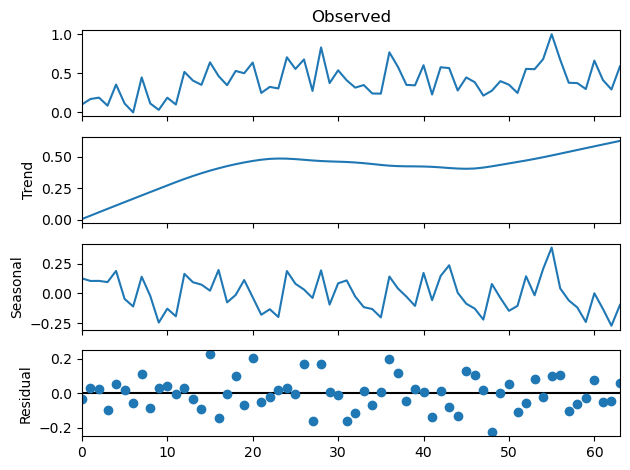

In [74]:
from statsmodels.tsa.seasonal import STL
stl = STL(series_scaled, period=12)   # monthly seasonality; set period=7 for weekly
res = stl.fit()
res.plot(); plt.show()

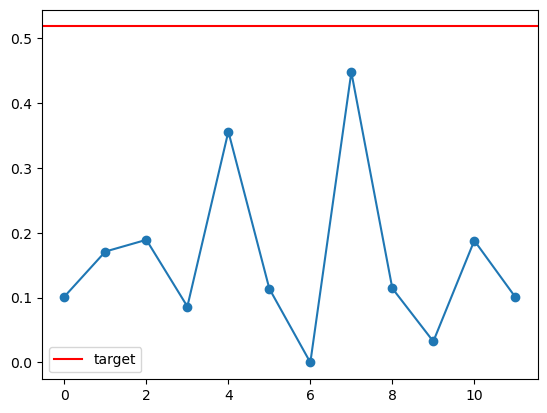

In [91]:
seq = xb[0].squeeze().cpu().numpy()
plt.plot(seq, marker='o')
plt.axhline(y=yb[0].item(), color='r', label='target')
plt.legend(); plt.show()

